
Model Training
====================

First we import all the functions. This Notebook will allow us to grab files for the training of a new model. Then we set up the loss functions that are going to be used in the model.

In [1]:
import tensorflow as tf
import numpy as np
from numpy import random
import os
from tqdm import tqdm
import cv2
from shutil import copy

import mask_prediction.unet_semantics as model_setup
import mask_prediction.data_retrievals as data
import mask_prediction.apply_weights as weights
import matplotlib.pyplot as plt

from glob import glob

print('Imports succesful!')



Imports succesful!


In [2]:
def dice_coeff(y_true, y_pred):
    """
    Measures the dice coefficient
    :param y_true: The true image for validation.
    :param y_pred: The image predicted by the network
    :return: Dice coefficient. The closer to one, the more the images are alike.
    """
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    """
    returns a dice coefficient which can be used as a loss parameter (aka, the closer to zero, the better)
    :param y_true: The true image for validation
    :param y_pred: The predicted image from the network
    :return: Dice loss, the closer to zero, the better.
    """
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


def dice_loss_weighted(y_true, y_pred):
    y0, y1, y2 = tf.split(y_true, [1, 1, 1], 3)
    # tf.print(tf.shape(y_pred))

    y_pred_weighted = tf.multiply(y_pred, y1)
    y_true_weighted = tf.multiply(y2, y1)

    loss = dice_loss(y_true_weighted, y_pred_weighted)
    return loss


def bce_dice_loss(y_true, y_pred):
    """
    Returns the sum of the binary cross entropy score and the dice loss score
    :param y_true: The true image for validation
    :param y_pred: The predicted image from the network
    :return: bce dice loss score
    """
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

    return loss


def bce_dice_loss_weighted(y_true, y_pred):
    y_mask, y_weights, y_amplify = tf.split(y_true, [1, 1, 1], 3)
    # tf.print(y2)

    y_pred_weighted = tf.multiply(y_pred, y_weights)
    y_true_weighted = tf.multiply(y_mask, y_weights)

    # tf.print(y_true_weighted)

    loss = tf.keras.losses.binary_crossentropy(y_true_weighted, y_pred_weighted) + dice_loss(y_true_weighted,
                                                                                             y_pred_weighted)

    return loss


def MSE_loss_weighted(y_true, y_pred):
    y_mask, y_weights, y_amplify = tf.split(y_true, [1, 1, 1], 3)
    # tf.print(y_mask)

    y_amplify = tf.add(tf.multiply(y_amplify, 9.0), 1.0)

    y_pred_weighted = tf.multiply(y_pred, y_weights)
    y_true_weighted = tf.multiply(y_mask, y_weights)
    relevant_pixels = tf.reduce_sum(y_weights)
    relevant_pixels = tf.add(relevant_pixels, 1.0)
    # tf.print(relevant_pixels)

    loss_img_1 = tf.square(tf.subtract(y_pred_weighted, y_true_weighted))
    loss_img_2 = tf.multiply(y_amplify, loss_img_1)
    loss = tf.divide(tf.reduce_sum(loss_img_2), relevant_pixels)

    return loss

________________
Initialising
---------
- First the train and test model folders are set up.
- We're setting up the environment, and initialise some file names.


In [3]:
##### GPU setup #####
os.environ["CUDA_VISIBLE_DEVICES"]="0"    #chose which GPU to use (0-3)

##### CPU setup #####
os.environ['MKL_NUM_THREADS'] = '20'     #chose the amount of CPUs to use, idk if this is working right now?
os.environ['GOTO_NUM_THREADS'] = '20'    #however, maybe works if GPU is not present/working
os.environ['OMP_NUM_THREADS'] = '20'
os.environ['openmp'] = 'True'

Training parameters
--
The model can be trained both on manually annotated masks, and partially annotated masks, based on a paper by Qu et. al.
Another option is to use secondary data in the training set or not. By default this will look up the Hoechst data in the datasets.
Preprocessing on the input data can also be done, by normalizing or even thresholding this secondary dataset.

To initialize the training set, a percentage of the training data can also be used to populate the testing folders.

In [4]:
##### General variables #####
IMG_SIZE = 1024     #size in pixels of 1 EM tile
BATCH_SIZE = 4          #How many images to take in at once on the GPU.

##### Parameters of this particular run #####
model_name = 'partial_em_points_check'
ini_data_path = 'X:\\BEP_data\\'#File containing data structure
Ho_adjust = False               #Threshold the Hoechst for the purpose of amplification.
normalize = True                #Whether to normalize the secondary data coming in
using_weights = True           #Whether weights are used within the mask data
TRAIN_WITH_FM = False            #Use the FM data when training. Creates model with either 3 (True) or 1 (False) input channels.
PATIENCE = 50                   #How many epochs with no discernable difference in loss to wait before prematurely terminating training.
TRAIN_TEST_SPLIT = .8           #What percentage of available mask images will be used as training data. The inverse will be used as validation data.

##### Folders that will be used in this run #####

dataset = 'RL012'
mask_folder = 'X:\\BEP_data\\Predict_backups\\sup_base_emho_2021-05-20_08-58-13\\Output'.format(dataset)       #Folder containing manually annotated masks
train_folder = 'X:\\BEP_data\\Train_set'#Folder from which the model will collect training images
test_folder = 'X:\\BEP_data\\Test_set'   #Folder from which the model will collect validation images
em_folder = 'X:\\BEP_data\\{}\\EM'.format(dataset)
ho_folder = 'X:\\BEP_data\\{}\\Hoechst'.format(dataset)
prt_ann_folder = 'X:\\BEP_data\\Partial Annotation\\temp'#Folder in which the weighted masks are stored that are used in partial annotation.
mask_list =  glob(mask_folder + '\\*.png')              #Glob string filtering which masks to take.

print('Loaded all variables.')
print('This run will use {} masks with EM input and {} {} {}'.format(('non-weighted', 'weighted')[using_weights], ('no other data', 'Hoechst data, which is')[TRAIN_WITH_FM], (' ', 'normalized,')[TRAIN_WITH_FM*normalize], (' ', 'thresholded')[TRAIN_WITH_FM*Ho_adjust]))

Loaded all variables.
This run will use weighted masks with EM input and no other data    


In [5]:
data_paths = (train_folder, test_folder, em_folder, ho_folder)


def choice(str_list, percent, seed=4):
    np.random.seed(seed)
    random.shuffle(str_list)
    cut = int(len(str_list) * percent)
    return str_list[:cut], str_list[cut:]

print('Converting masks to weights...')

if using_weights:
    for image_name in glob(prt_ann_folder + '\\*.png'):
        os.remove(image_name)
    ITERATION_COUNT = 4     #How many partial annotation iterations to go over before calling the model done.
    size_filter = 5e7       #area in pixels which has to cover the weights image for it to be used in training. (pixel values range from 0 to 255)
    pnt_ratio = .8          #ratio of blobs which will be used in the final image.

    radius_array = weights.get_radius_sample('X:\\BEP_data\\Train_set\\blobs\\1\\')
    mean_diam = np.mean(radius_array, dtype=int)

    point_mask_list = weights.convert_partial_annotation(mask_folder, prt_ann_folder, mean_diam, IMG_SIZE=IMG_SIZE, pnt_ratio=pnt_ratio, size_filter=size_filter)

print('Done, shuffling datasets...')

train_list, test_list = choice((mask_list, point_mask_list)[using_weights], TRAIN_TEST_SPLIT)
train_list.sort()

print('Done, populating training/testing folders...')

for image_name in glob(train_folder + '\\Train_masks\\1\\*.png'):
    os.remove(image_name)
for image_name in glob(train_folder + '\\Train_data\\1\\*.png'):
    os.remove(image_name)
for image_name in glob(test_folder + '\\Test_masks\\1\\*.png'):
    os.remove(image_name)
for image_name in glob(test_folder + '\\Test_data\\1\\*.png'):
    os.remove(image_name)


for train in train_list:
    copy(train, train_folder + '\\Train_masks\\1')
train_data_list = data.gen_input_from_mask(data_paths, work_with_fm= TRAIN_WITH_FM, adjust_test=False, dataset=dataset, normalize=normalize)
for test in test_list:
    copy(test, test_folder + '\\Test_masks\\1')
data.gen_input_from_mask(data_paths, work_with_fm=TRAIN_WITH_FM, adjust_test=True, dataset=dataset, normalize=normalize)

print('Training on {} images'.format(len(train_list)))
print('Testing on {} images'.format(len(test_list)))

example_mask = cv2.imread(train_list[4])
example_data = cv2.imread(train_data_list[4])


Converting masks to weights...


X:\BEP_Project\mask_prediction\apply_weights.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sample_array = rng.choice(pts_array, sample_size, replace=False, axis=0)


Done, shuffling datasets...
Done, populating training/testing folders...
Training on 69 images
Testing on 18 images


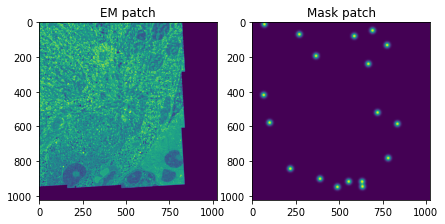

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(7,7))
ax1.imshow(example_data[:,:,0])
ax1.set_title('EM patch')
ax2.imshow(example_mask[:,:,0])
ax2.set_title('Mask patch')
plt.show()


Next the model is trained.

In [7]:
model_export = 'X:\\BEP_Project\\Models\\{}'.format(model_name)
IMG_CHANNELS = (1,3)[TRAIN_WITH_FM]

model, train_generator, test_generator = model_setup.Train_Model(ini_data_path, IMG_CHANNELS=3,
                                                     normalize=False, using_weights=using_weights,)

model.compile(optimizer='adam', loss=([bce_dice_loss], [MSE_loss_weighted])[using_weights],
              metrics=([dice_loss], [bce_dice_loss_weighted])[using_weights])

checkpointer = tf.keras.callbacks.ModelCheckpoint('{}.h5'.format('10jan1058'), verbose=1, save_best_only=True)
callbacks = [tf.keras.callbacks.EarlyStopping(patience=PATIENCE),
             tf.keras.callbacks.TensorBoard(log_dir='logs', histogram_freq=1)]

results = model.fit(train_generator, validation_data=test_generator, steps_per_epoch=len(train_list) // BATCH_SIZE,
                    validation_steps=len(test_list) // BATCH_SIZE,
                    epochs=1000, callbacks=callbacks, batch_size=BATCH_SIZE)
model.save(model_export + '.h5', include_optimizer=False)
print('Done! Model can be found in ' + model_export)


Found 69 images belonging to 1 classes.
Found 69 images belonging to 1 classes.
Found 18 images belonging to 1 classes.
Found 18 images belonging to 1 classes.
Epoch 1/1000
17/17 [==============================] - 26s 324ms/step - loss: 0.2994 - bce_dice_loss_weighted: 0.8651 - val_loss: 0.3003 - val_bce_dice_loss_weighted: 0.8951